## Задание 1
#### Архитектура Transformer

Трансформер — архитектура глубоких нейронных сетей, представленная в 2017 году исследователями из Google Brain.

По аналогии с рекуррентными нейронными сетями (RNN) трансформеры предназначены для обработки последовательностей, таких как текст на естественном языке, и решения таких задач как машинный перевод. 

Архитектура трансформер состоит из кодировщика и декодировщика. Кодировщик получает на вход векторизованую последовательность с позиционной информацией. Декодировщик получает на вход часть этой последовательности и выход кодировщика. Кодировщик и декодировщик состоят из слоев. Слои кодировщика последовательно передают результат следующему слою в качестве его входа. Слои декодировщика последовательно передают результат следующему слою вместе с результатом кодировщика в качестве его входа.

Преимущества архитектуры Transformer (над RNN и CNN)
- Все слова в предложении одинаково доступны при кодировании/декодировании (расстояние не важно)
- Может эффективно выполняться параллельно, т.к. трансформеру не требуется обрабатывать конец текста после обработки его начала
- Эффективная глубина сети меньше по сравнению с RNN (RNN "разматывается" вдоль последовательности), в Transformer глубина графа не зависит от длины последовательности

В результате, появились такие модели как: BERT (Bidirectional Encoder Representations from Transformers) И GPT (Generative Pre-trained Transformer)

Организация декодера
- декодер запускается по слову за раз, получает на вход:
    - вектора всех исходных слов, полученные при энкодинге
    - все прошлые слова и должен выдать следующее (на первой итерации получает специальный токен )
- соответственно, декодер состоит из двух блоков:
    - первый — работает с векторами предыдущих декодированных слов, аналогичный использованному в процессе encoding (но может обращаться не ко всем слвам, а только к уже декодированным).
    - второй — работает с выходом энкодера. B этом случае Query — это вектор входа в декодере, а пары Key/Value — это финальные эмбеддинги энкодера
- все это снова повторяется 6 раз (глубокое обучение!), где выход предыдущего блока идет на вход следующему
- в конце сети стоит softmax, который выдает вероятности слов. Сэмплирование из него и есть результат, то есть следующее слово в предложении.
- Результат семплирования подается на вход следующему запуску декодера и процесс повторяется, пока декодер не выдаст токен EOS

## Задание 2

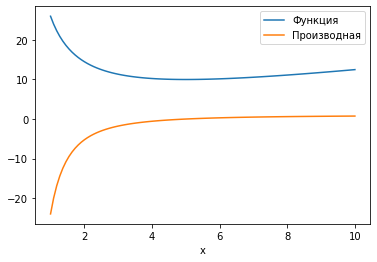

In [272]:
import torch
import matplotlib.pyplot as plt

def f(x):
    return (x ** 2 + 25) / x

x = torch.linspace(1, 10, 100, requires_grad = True)
Y = f(x)
y = torch.sum(Y)
y.backward()

plt.plot(x.detach().numpy(), Y.detach().numpy(), label = 'Функция')
plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label = 'Производная')
plt.xlabel('x')
plt.legend()
plt.show()

In [8]:
x0 = 2
x = torch.tensor([x0], requires_grad=True, dtype=torch.float)

params = [x]
lr = 0.01
epoch = 1000
y_values = []
optimizer = torch.optim.Adam(params, lr=lr)
minimum = f(x)
for i in range(epoch):
    optimizer.zero_grad()
    
    f_val = f(x)
    f_val.backward()
    
    new_y = f_val.item()
    
    if (new_y < minimum):
        minimum = new_y
    elif (new_y > minimum) or x.item() < 1 or x.item() > 10:
        break
        
    y_values.append(new_y)
    
    optimizer.step()

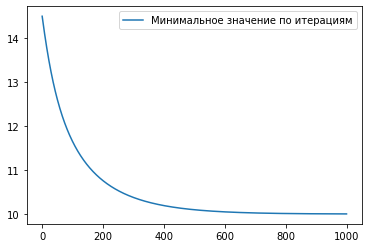

In [13]:
plt.plot(y_values, label='Минимальное значение по итерациям')
plt.legend()
plt.show()

In [12]:
print(f'Минимальный x = {x.item()}, минимальный y = {y_values[-1]}')

Минимальный x = 4.8971099853515625, минимальный y = 10.002181053161621


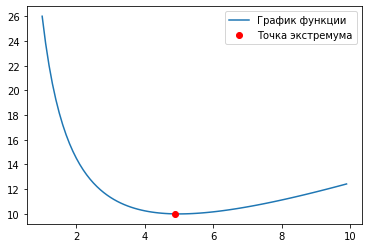

In [15]:
plt.plot(torch.arange(1, 10, 0.1), f(torch.arange(1, 10, 0.1)), label='График функции')
plt.plot(x.item(), y_values[-1], 'ro', label='Точка экстремума')
plt.legend()
plt.show()

## Задание 3

In [236]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [17]:
gold = pd.read_csv("gold.csv")
print(gold.shape)
gold.head()

(2558, 121)


,3M Libor_T-1,EM Bond_T-1,US Bond ETF_T-1,Wheat 1_T-1,Wheat 2_T-1,Crude Palm Oil_T-1,Brent 1_T-1,Brent 2_T-1,Light Crude_T-1,White Sugar_T-1,...,MSCI EM_T-22,Shanghai Index_T-22,Nikkei Ind_T-22,MSCI APAC ex J_T-22,EMEquity ETF_T-22,Silver_T-22,Platinum_T-22,Palladium_T-22,Gold_T-22,Gold_T+22
0,0.000000,0.000879,0.001050,0.013158,0.013562,0.003163,-0.007879,-0.004945,-0.003486,-0.024706,...,-0.009862,0.073090,-0.028816,-0.001613,-0.012274,-0.025210,0.024300,0.082695,0.053534,0.004648
1,-0.004587,0.004096,0.002383,0.043599,0.041035,0.040991,0.042356,0.039759,0.029667,0.047906,...,0.006801,0.099088,-0.043704,0.007670,0.018151,0.060624,0.068595,0.151468,0.085822,-0.002105
2,-0.003465,-0.002040,0.000856,0.020444,0.017995,0.003462,0.006222,0.006541,0.007172,0.005262,...,0.014873,0.102887,-0.051438,0.007525,0.028712,0.056289,0.083520,0.134763,0.083915,-0.037438
3,-0.004624,0.000584,-0.002090,-0.015679,-0.012626,0.021992,0.003029,0.004249,0.002498,0.020775,...,0.004931,0.087208,-0.054678,0.005445,0.001445,0.041620,0.061601,0.109940,0.076738,-0.028097
4,-0.009292,-0.000486,0.001047,-0.003540,-0.002558,-0.012658,-0.024912,-0.022026,-0.023551,-0.025000,...,-0.003838,0.076564,-0.076171,-0.009558,-0.003904,0.058352,0.069414,0.094311,0.084487,-0.045466


In [18]:
gold.describe()

,3M Libor_T-1,EM Bond_T-1,US Bond ETF_T-1,Wheat 1_T-1,Wheat 2_T-1,Crude Palm Oil_T-1,Brent 1_T-1,Brent 2_T-1,Light Crude_T-1,White Sugar_T-1,...,MSCI EM_T-22,Shanghai Index_T-22,Nikkei Ind_T-22,MSCI APAC ex J_T-22,EMEquity ETF_T-22,Silver_T-22,Platinum_T-22,Palladium_T-22,Gold_T-22,Gold_T+22
count,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,...,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000
mean,0.000832,0.000054,0.000035,0.000105,0.000083,0.000081,0.000063,0.000048,0.000039,-0.000126,...,0.001521,0.001640,0.007724,0.002843,0.001348,0.003429,-0.002040,0.016255,0.004002,0.003222
std,0.007570,0.004277,0.002073,0.018729,0.017929,0.014268,0.018331,0.017958,0.019077,0.016468,...,0.050782,0.067590,0.055285,0.047920,0.053453,0.082057,0.058466,0.081979,0.044998,0.044198
min,-0.075051,-0.044433,-0.012440,-0.086872,-0.090000,-0.112903,-0.084337,-0.083457,-0.100408,-0.117669,...,-0.186586,-0.316587,-0.188626,-0.185257,-0.194926,-0.303009,-0.212727,-0.267772,-0.149107,-0.149107
25%,-0.002105,-0.001950,-0.001127,-0.011117,-0.010545,-0.006871,-0.009334,-0.009379,-0.010202,-0.008780,...,-0.028663,-0.037221,-0.025363,-0.024215,-0.031686,-0.049056,-0.041553,-0.037162,-0.023329,-0.023619
50%,0.000000,0.000092,0.000091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003532,0.002802,0.011238,0.006085,0.002076,-0.005047,-0.004983,0.018242,0.001952,0.001441
75%,0.003278,0.002254,0.001346,0.010361,0.009619,0.006567,0.009706,0.009532,0.010429,0.008175,...,0.035178,0.036260,0.044586,0.033261,0.037184,0.052980,0.039107,0.069460,0.032227,0.031532
max,0.145989,0.033682,0.008395,0.093916,0.118492,0.153199,0.089039,0.090140,0.099622,0.104769,...,0.182996,0.275124,0.193466,0.189002,0.194412,0.305908,0.223757,0.288488,0.194723,0.194723


In [20]:
gold.isnull().sum().sort_values()

3M Libor_T-1           0
Platinum_T-14          0
Silver_T-14            0
EMEquity ETF_T-14      0
MSCI APAC ex J_T-14    0
                      ..
Wheat 1_T-7            0
US Bond ETF_T-7        0
EM Bond_T-7            0
Gold_T-7               0
Gold_T+22              0
Length: 121, dtype: int64

Пропусков нет, ничего дополнять или удалять из строк не нужно

In [22]:
gold.nunique().sort_values()

3M Libor_T-1          2020
Crude Palm Oil_T-1    2104
Yuan_T-1              2295
3M Libor_T-7          2298
MR_T-1                2306
                      ... 
MSCI EM_T-14          2558
Gold_T-7              2558
MSCI APAC ex J_T-7    2558
Gold_T-14             2558
MSCI EM_T-7           2558
Length: 121, dtype: int64

Все столбцы не категориальные

In [23]:
target = 'Gold_T+22'

In [24]:
X = gold.drop(labels=[target], axis=1)
y = gold[target]

Предобработает входные данные методом StandardScaler

In [27]:
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

In [264]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=1)
X_train.shape

(1918, 120)

In [265]:
class NN(nn.Module):
    def __init__(self, n_features):
        super(NN, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(n_features, n_features*4), nn.Sigmoid())
        self.layer2 = nn.Sequential(nn.Linear(n_features*4, n_features*2), nn.Sigmoid())
        self.layer3 = nn.Sequential(nn.Linear(n_features*2, n_features), nn.Sigmoid())
        self.layer4 = nn.Linear(n_features, 1) 

    def forward(self, x):
        x = self.layer1(x)  
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

model = NN(X_train.shape[1])
print(model)

NN(
  (layer1): Sequential(
    (0): Linear(in_features=120, out_features=480, bias=True)
    (1): Sigmoid()
  )
  (layer2): Sequential(
    (0): Linear(in_features=480, out_features=240, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=240, out_features=120, bias=True)
    (1): Sigmoid()
  )
  (layer4): Linear(in_features=120, out_features=1, bias=True)
)


In [266]:
X_train = torch.tensor(np.array(X_train),dtype=torch.float32,requires_grad=True)
y_train = torch.tensor(np.array(y_train).reshape(-1,1),dtype=torch.float32)
X_test = torch.tensor(np.array(X_test),dtype=torch.float32)
y_test = torch.tensor(np.array(y_test).reshape(-1,1),dtype=torch.float32)

In [267]:
loss_fn=nn.MSELoss()
optimizer= torch.optim.SGD(model.parameters(),lr=0.01)

In [268]:
epochs = 1500
losses = []
for i in range(epochs):
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()
    if i % 20 == 0:
        losses.append(loss.item())
    if i % 50 == 0:
        print(f"epochs:{i}\tloss:{loss}")

epochs:0	loss:0.22631387412548065
epochs:50	loss:0.0018969259690493345
epochs:100	loss:0.0018968727672472596
epochs:150	loss:0.0018968196818605065
epochs:200	loss:0.0018967664800584316
epochs:250	loss:0.0018967135110870004
epochs:300	loss:0.0018966603092849255
epochs:350	loss:0.0018966073403134942
epochs:400	loss:0.001896554371342063
epochs:450	loss:0.0018965017516165972
epochs:500	loss:0.001896448666229844
epochs:550	loss:0.0018963958136737347
epochs:600	loss:0.0018963429611176252
epochs:650	loss:0.001896289992146194
epochs:700	loss:0.00189623748883605
epochs:750	loss:0.0018961845198646188
epochs:800	loss:0.0018961316673085093
epochs:850	loss:0.0018960791639983654
epochs:900	loss:0.001896026311442256
epochs:950	loss:0.0018959739245474339
epochs:1000	loss:0.0018959211884066463
epochs:1050	loss:0.0018958685686811805
epochs:1100	loss:0.0018958160653710365
epochs:1150	loss:0.0018957637948915362
epochs:1200	loss:0.0018957114079967141
epochs:1250	loss:0.0018956589046865702
epochs:1300	loss:

In [269]:
y_train_pred = model(X_train).detach().numpy()
y_test_pred = model(X_test).detach().numpy()

In [270]:
test_accuracy = r2_score(y_test, y_test_pred)
train_accuracy = r2_score(y_train, y_train_pred)
print('R^2 на обучающем множестве', train_accuracy)
print('R^2 на тестовом множестве', test_accuracy)

R^2 на обучающем множестве -0.0010905143312838206
R^2 на тестовом множестве -0.0009033765879027378


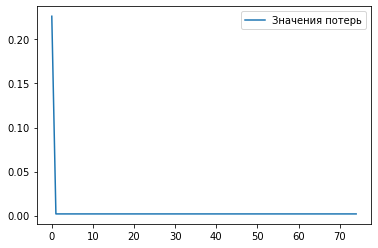

In [271]:
plt.plot(losses, label='Значения потерь')
plt.legend()
plt.show()